Original GT first position: [4.000, -0.060, 1.800]
Transformed GT first position: [0.000, 0.000, 0.000]


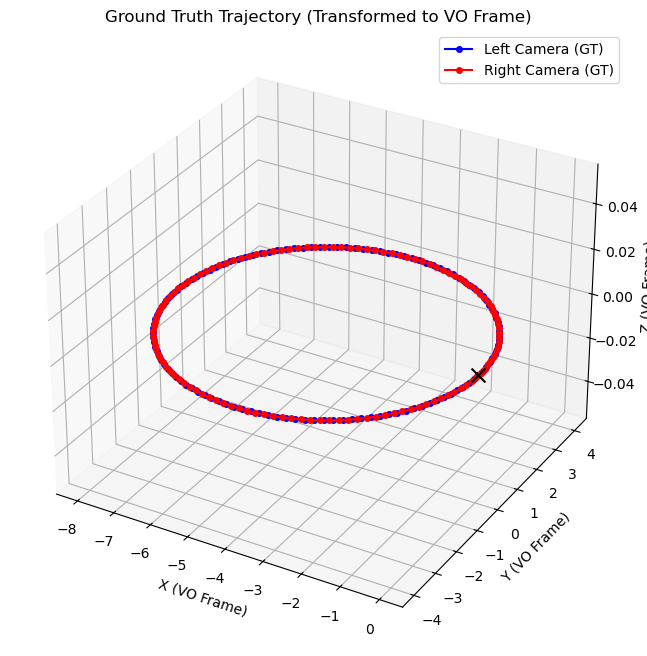

In [9]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2


with open('maximum_feature_office_dataset/ground_truth_poses.json', 'r') as file:
    ground_truth = json.load(file)

# Extract pose data
poses = ground_truth['poses']

# Extract left camera positions 
left_positions = []
for pose in poses:
    left_trans = pose['left_camera']['translation']
    left_positions.append([left_trans[0], left_trans[1], left_trans[2]])

left_positions = np.array(left_positions)

# Transform to VO coordinate frame 
first_position = left_positions[0].copy()
gt_transformed = left_positions - first_position

print(f"Original GT first position: [{first_position[0]:.3f}, {first_position[1]:.3f}, {first_position[2]:.3f}]")
print(f"Transformed GT first position: [{gt_transformed[0][0]:.3f}, {gt_transformed[0][1]:.3f}, {gt_transformed[0][2]:.3f}]")


left_x = gt_transformed[:, 0]
left_y = gt_transformed[:, 1] 
left_z = gt_transformed[:, 2]


right_positions = []
for pose in poses:
    right_trans = pose['right_camera']['translation']
    right_positions.append([right_trans[0], right_trans[1], right_trans[2]])

right_positions = np.array(right_positions)
right_transformed = right_positions - first_position  

right_x = right_transformed[:, 0]
right_y = right_transformed[:, 1]
right_z = right_transformed[:, 2]

# 3D plot in VO coordinate frame
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(left_x, left_y, left_z, 'b-o', label='Left Camera (GT)', markersize=4)
ax.plot(right_x, right_y, right_z, 'r-o', label='Right Camera (GT)', markersize=4)

ax.set_xlabel('X (VO Frame)')
ax.set_ylabel('Y (VO Frame)')
ax.set_zlabel('Z (VO Frame)')
ax.set_title('Ground Truth Trajectory (Transformed to VO Frame)')
ax.legend()


ax.scatter([0], [0], [0], color='black', s=100, marker='x', label='VO Origin (Frame 1)')

plt.show()


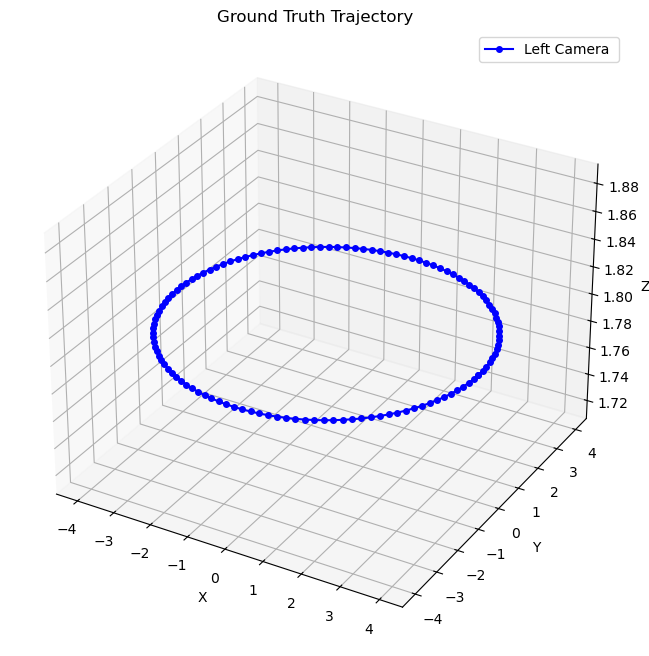

In [10]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2


with open('maximum_feature_office_dataset/ground_truth_poses.json', 'r') as file:
    ground_truth = json.load(file)

# Extract pose data
poses = ground_truth['poses']

# Extract left camera positions (we'll use left camera as reference)
left_positions = []
for pose in poses:
    left_trans = pose['left_camera']['translation']
    left_positions.append([left_trans[0], left_trans[1], left_trans[2]])

left_positions = np.array(left_positions)


# 3D plot in VO coordinate frame
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(left_positions[:, 0], left_positions[:, 1], left_positions[:, 2], 'b-o', label='Left Camera ', markersize=4)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z ')
ax.set_title('Ground Truth Trajectory ')
ax.legend()
plt.show()






In [11]:
import cv2 
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import cv2



class SIFT:
    def __init__(self, n_features=500):
        self.n_features = n_features
        self.sift = cv2.SIFT_create(nfeatures=self.n_features)
    

    def detect_and_compute(self, image, mask=None):
        """Detect keypoints and compute descriptors."""
        gray_image = convert_to_grayscale(image)
        keypoints, descriptors = self.sift.detectAndCompute(gray_image, mask)

        keypoints_location = np.array([kp.pt for kp in keypoints])
        

        return keypoints, descriptors, keypoints_location
    
    def match_features(self, descriptors1, descriptors2):
        """Match features between two sets of descriptors using Lowe's ratio test."""
        if descriptors1 is None or descriptors2 is None:
            return []

        
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)


        query_idx = [m.queryIdx for m in good_matches]
        train_idx = [m.trainIdx for m in good_matches]

        return good_matches, query_idx, train_idx
    
def convert_to_grayscale(image):
    if image.ndim == 3:  
        return (0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]).astype(np.uint8)
    else:
        return image




In [ ]:
import pandas as pd

vo_poses = pd.read_csv('utils/vo_poses_aruco_every_2nd_frame.csv')
aruco_poses = pd.read_csv('utils/marker_poses.csv')

x_aruco = np.array(aruco_poses['x'])
y_aruco = np.array(aruco_poses['y'])
z_aruco = np.array(aruco_poses['z'])

x_vo = np.array(vo_poses['x'])
y_vo = np.array(vo_poses['y'])
z_vo = np.array(vo_poses['z'])



frame_numbers = np.array(aruco_poses['frame']) - 1

x_vo = x_vo[frame_numbers]
y_vo = y_vo[frame_numbers]
z_vo = z_vo[frame_numbers]


error_x = abs(x_aruco - x_vo)
error_y = abs(y_aruco - y_vo)
error_z = abs(z_aruco - z_vo)

error_data = {
    "frame": frame_numbers,
    "x": error_x,
    "y": error_y, 
    "z": error_z, 
}

error = pd.DataFrame(error_data)


max_error_x = max(error_x)
print(max_error_x)

index_of_x_error = np.where(error == max_error_x)
print(f"The frame where the max error in x is, is: {index_of_x_error[0]} ")

max_error_y = max(error_y)
print(max_error_y)

max_error_z = max(error_z)
print(max_error_z)


0.809365801239541
The frame where the max error in x is, is: [76] 
0.910706848969685
0.2476480918789532


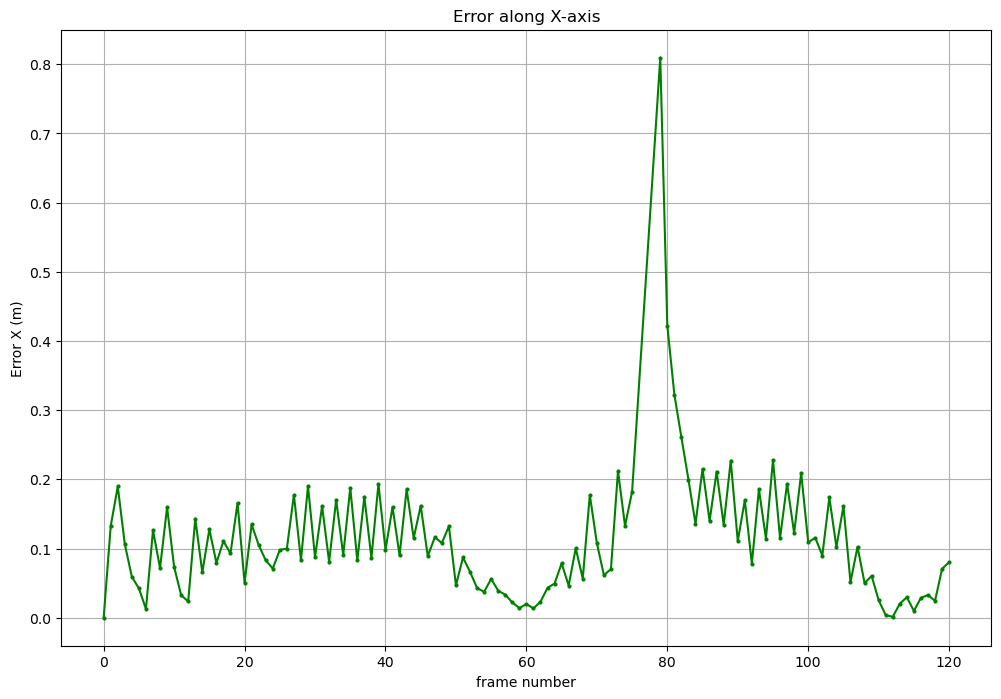

In [39]:
# Plot comparison
plt.figure(figsize=(12, 8))


#plt.subplot(2, 3, 1)
plt.plot(frame_numbers, error_x, 'g-o', markersize=2)
plt.title('Error along X-axis')
plt.xlabel('frame number')
plt.ylabel('Error X (m)')
#plt.axis('equal')
plt.grid(True)



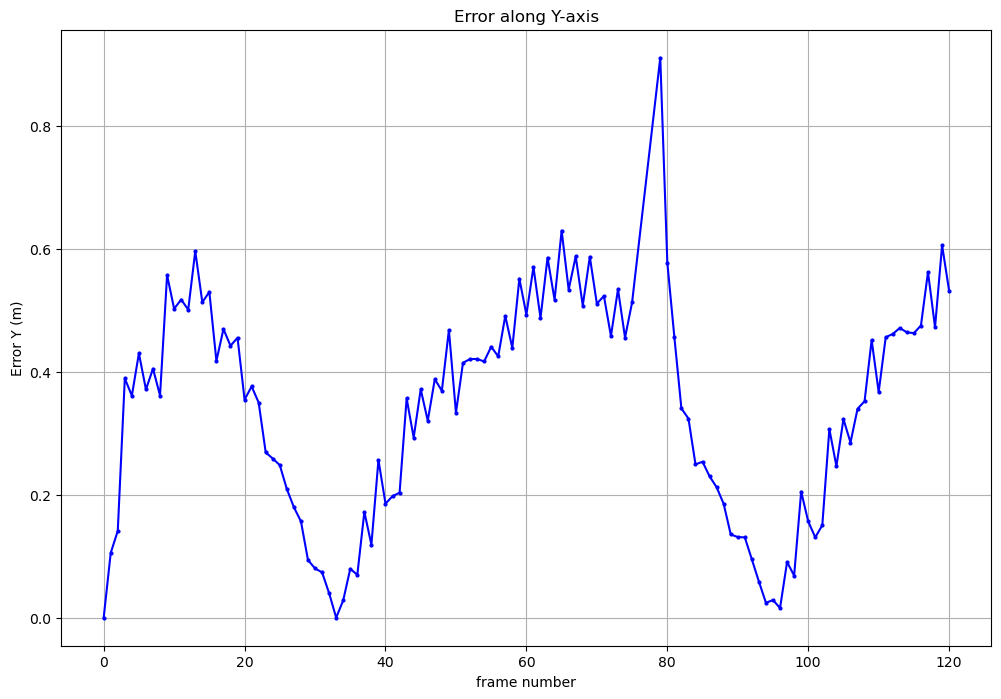

In [45]:

plt.figure(figsize=(12, 8))
plt.plot(frame_numbers, error_y, 'b-o', markersize=2)
plt.title('Error along Y-axis')
plt.ylabel('Error Y (m)')
plt.xlabel('frame number')
#plt.axis('equal')
plt.grid(True)


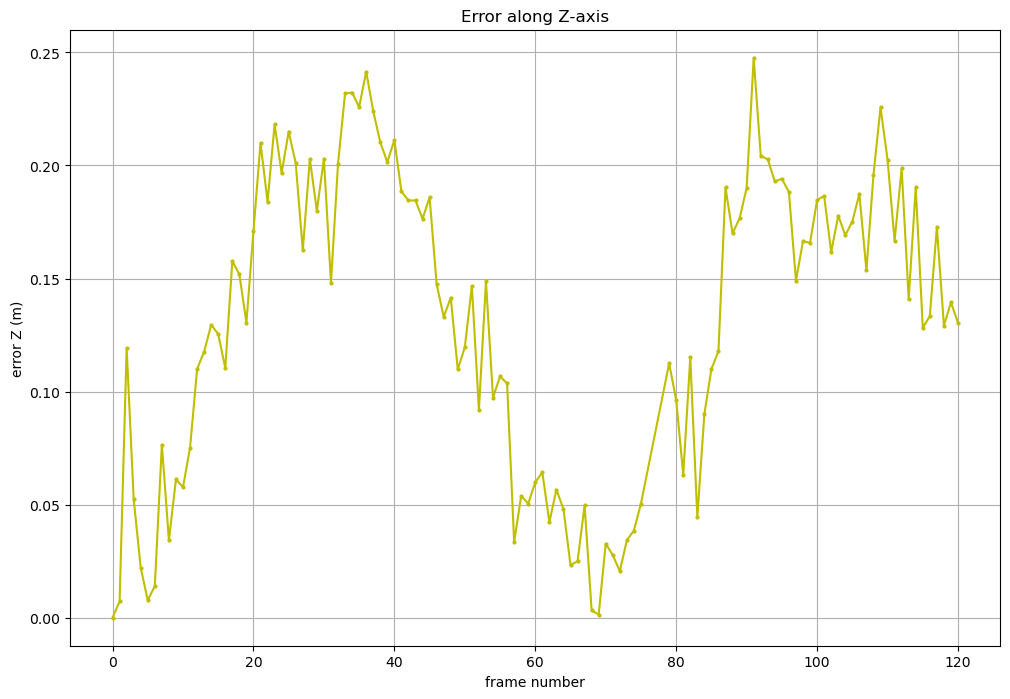

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(frame_numbers, error_z, 'y-o', markersize=2)
plt.title('Error along Z-axis')
plt.ylabel('error Z (m)')
plt.xlabel('frame number')
plt.grid(True)